# Library

In [32]:
import requests
from requests_oauthlib import OAuth1
import json
import pandas as pd
from datetime import date, timedelta, datetime
from IPython.display import display
%matplotlib inline
import numpy as np

# Functions

In [2]:
HEADERS = {'content-type': 'application/json'}

def parse_resp(resp, dtype='dataframe'):
    """
    Parse response

    Parameters
    ----------
    resp : requests.models.Response
    dtype : {"dict", "dataframe"}, optional
        Return data type
    """
    parsed = json.loads(resp.text)
    if dtype.lower() == 'dict':
        return parsed
    elif dtype.lower() == 'dataframe':
        return pd.DataFrame(parsed).T
    else:
        raise ValueError('Invalid "dtype" {}'.format(dtype))


def urljoin(*args):
    """
    Join arguments into a url. Trailing and leading slashes are
    stripped from each argument.
    """
    return '/'.join(s.strip('/') for s in args)


def strjoin(*args):
    """
    Join arguments into a string.

    Examples
    --------
    >>> strjoin('foo', 'bar')  # 'foo,bar'
    """
    return ','.join(args)


def split_rows(df, columns):
    """
    Split values in `columns` of `df` into various rows.

    Parameters
    ----------
    df : Pandas DataFrame
    columns : list, tuple, str

    Returns
    -------
    Pandas DataFrame
    """

    if df.empty:
        return df

    if isinstance(columns, basestring):
        columns = [columns]

    exploded = pd.DataFrame()
    df_split = df.reset_index()

    original_columns = df.columns
    original_indices = list(set(df_split.columns) - set(original_columns))

    for cc in columns:
        s = df_split[cc].apply(pd.Series).stack()
        s.index = s.index.droplevel(-1)
        s.name = cc
        exploded = pd.concat([exploded, s], axis=1)

    static_columns = [cc for cc in original_columns if cc not in columns]
    df_split = (pd
                .concat([df_split[original_indices + static_columns],
                         exploded],
                        axis=1)
               .set_index(original_indices))[original_columns]

    return df_split

# Code

## Getting Twitter credentials

In [3]:
def twitter_conn():

    from requests_oauthlib import OAuth1

    CONSUMER_KEY = ''
    CONSUMER_SECRET = ''
    ACCESS_TOKEN = ''
    ACCESS_TOKEN_SECRET = ''
    ACCOUNT_ID = ''
    AS_USER_ID = ''

    auth = OAuth1(CONSUMER_KEY, CONSUMER_SECRET,
               ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
    print 'Twitter connection successfully initiated!'
    return auth

## Getting Twitter direct messages

In [4]:
twi_conn = twitter_conn()
url = 'https://api.twitter.com/1.1/direct_messages/events/list.json?'

params = {'count':100}
resp = requests.get(url, auth=twi_conn, params=params)

parsed = parse_resp(resp, dtype='dict')
report_to_explode = pd.DataFrame(parsed['events'])
report_to_explode

Twitter connection successfully initiated!


,created_timestamp,id,message_create,type
0,1501986557621,894022537033773059,"{u'message_data': {u'text': u'@Adulto_cm', u'e...",message_create
1,1501986170676,894020914068803587,"{u'message_data': {u'text': u'kk', u'entities'...",message_create
2,1501985783881,894019291732987913,"{u'message_data': {u'text': u'aaa', u'entities...",message_create
3,1501984348830,894013272692854787,"{u'message_data': {u'text': u'teste', u'entiti...",message_create
4,1501983263167,894008719092178947,"{u'message_data': {u'text': u'me respondeee', ...",message_create
5,1501982689176,894006311599439875,"{u'message_data': {u'text': u'tudo bem?', u'en...",message_create
6,1501981604298,894001761291313155,"{u'message_data': {u'text': u'oi', u'entities'...",message_create


## Cleaning data

In [15]:
ii=0
while ii < len(report_to_explode):
    message_content = pd.DataFrame(report_to_explode.loc[ii, 'message_create']) \
                        .loc['text', ['message_data', 'sender_id']].reset_index().transpose()
    sender_data = pd.DataFrame(pd.DataFrame(report_to_explode.loc[0,'message_create']) \
                        .loc['entities','message_data']['user_mentions'])
    user_data = pd.DataFrame([{u'id_str': '893999773262516224', u'screen_name': u'kid'}])
    if str(message_content.loc['text',1]) == '893999773262516224':
        dirty_df = message_content.merge(user_data, left_on=1, right_on='id_str')\
              .rename(columns={0:'message', 'screen_name':'sender_name'})
    else:
        dirty_df = message_content.merge(sender_data, left_on=1, right_on='id_str') \
              .rename(columns={0:'message', 'screen_name':'sender_name'})
    dirty_df = dirty_df.loc[:,['message', 'sender_name']]
    dirty_df = dirty_df.set_index([[ii]])
    clean_df = dirty_df.merge(report_to_explode, left_index=True, right_index=True)
    clean_df = clean_df.loc[:,['sender_name', 'created_timestamp', 'message']]
    if ii==0:
        df = clean_df
    else:
        df = df.append(clean_df)
    ii=ii+1

In [19]:
df

,sender_name,created_timestamp,message
0,kid,1501986557621,@Adulto_cm
1,Adulto_cm,1501986170676,kk
2,kid,1501985783881,aaa
3,kid,1501984348830,teste
4,kid,1501983263167,me respondeee
5,kid,1501982689176,tudo bem?
6,Adulto_cm,1501981604298,oi


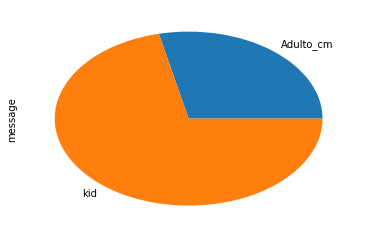

In [36]:
df.groupby(['sender_name'])['message'].count().plot(kind='pie')

In [39]:
df.groupby(['sender_name'])['message'].count().reset_index()

,sender_name,message
0,Adulto_cm,2
1,kid,5


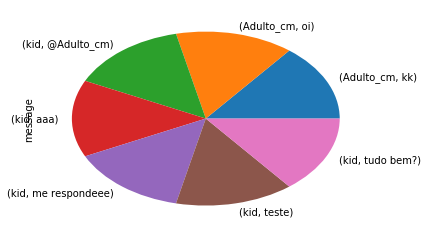

In [34]:
df.groupby(['sender_name', 'message'])['message'].count().plot(kind='pie')